<a href="https://colab.research.google.com/github/yuann403/Deep-Generative-Models/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用變分自編碼器（VAE）重建 MNIST 手寫數字

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# 設定環境變數解決OpenMP警告
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# 檢查GPU可用性
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
# VAE模型定義
class VAE(nn.Module):
  def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
    super(VAE, self).__init__()

    # Encoder
    self.encoder_fc1 = nn.Linear(input_dim, hidden_dim)
    self.encoder_fc2_mu = nn.Linear(hidden_dim, latent_dim)
    self.encoder_fc2_logvar = nn.Linear(hidden_dim, latent_dim)

    # Decoder
    self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim)
    self.decoder_fc2 = nn.Linear(hidden_dim, input_dim)

  def encode(self, x):
    """編碼器：將輸入轉換為潛在空間的均值和對數方差"""
    h = F.relu(self.encoder_fc1(x))
    mu = self.encoder_fc2_mu(h)
    logvar = self.encoder_fc2_logvar(h)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    """重參數化技巧：從標準正態分佈採樣"""
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z

  def decode(self, z):
    """解碼器：將潛在變數重建為圖像"""
    h = F.relu(self.decoder_fc1(z))
    recon_x = torch.sigmoid(self.decoder_fc2(h))
    return recon_x

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    recon_x = self.decode(z)
    return recon_x, mu, logvar

In [4]:
# VAE損失函數
def vae_loss(recon_x, x, mu, logvar):
  """VAE損失函數 = 重建損失 + KL散度"""
  # 重建損失（二元交叉熵）
  recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

  # KL散度
  kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return recon_loss + kl_loss

# 訓練函數
def train_vae(model, train_loader, optimizer, epoch):
  model.train()
  total_loss = 0

  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()

    recon_data, mu, logvar = model(data)
    loss = vae_loss(recon_data, data, mu, logvar)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader.dataset)
  return avg_loss

# 測試函數
def test_vae(model, test_loader):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for data, _ in test_loader:
      data = data.to(device)
      recon_data, mu, logvar = model(data)
      loss = vae_loss(recon_data, data, mu, logvar)
      total_loss += loss.item()

  avg_loss = total_loss / len(test_loader.dataset)
  return avg_loss

# 可視化結果函數
def visualize_reconstruction(model, test_loader, num_samples=8):
  model.eval()

  with torch.no_grad():
    # 取得測試資料
    data, _ = next(iter(test_loader))
    data = data[:num_samples].to(device)

    # 重建資料
    recon_data, _, _ = model(data)

    # 轉換為圖像格式
    data = data.cpu().view(-1, 28, 28)
    recon_data = recon_data.cpu().view(-1, 28, 28)

    # 繪製原始圖像和重建圖像
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))

    for i in range(num_samples):
      # 原始圖像
      axes[0, i].imshow(data[i], cmap='gray')
      axes[0, i].set_title('Input')
      axes[0, i].axis('off')

      # 重建圖像
      axes[1, i].imshow(recon_data[i], cmap='gray')
      axes[1, i].set_title('Reconstruction')
      axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig('reconstruction.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('已儲存重建圖檔 reconstruction.png')

# 主程序
def main():
  # 資料預處理：將圖像轉換為[0,1]範圍並展平為784維向量
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda x: x.view(-1))  # 展平為784維
  ])

  # 使用torchvision下載MNIST數據集
  train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  # 創建數據載入器
  train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

  # 創建模型
  model = VAE(input_dim=784, hidden_dim=400, latent_dim=20).to(device)

  # 創建優化器
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  # 訓練模型
  num_epochs = 5
  train_losses = []
  test_losses = []

  for epoch in range(1, num_epochs + 1):
    train_loss = train_vae(model, train_loader, optimizer, epoch)
    test_loss = test_vae(model, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch}, Average loss: {train_loss:.4f}')
  print("訓練完成!")

  # 可視化重建結果
  visualize_reconstruction(model, test_loader)

Epoch 1, Average loss: 165.8659
Epoch 2, Average loss: 121.6734
Epoch 3, Average loss: 114.6492
Epoch 4, Average loss: 111.6602
Epoch 5, Average loss: 109.8635
訓練完成!


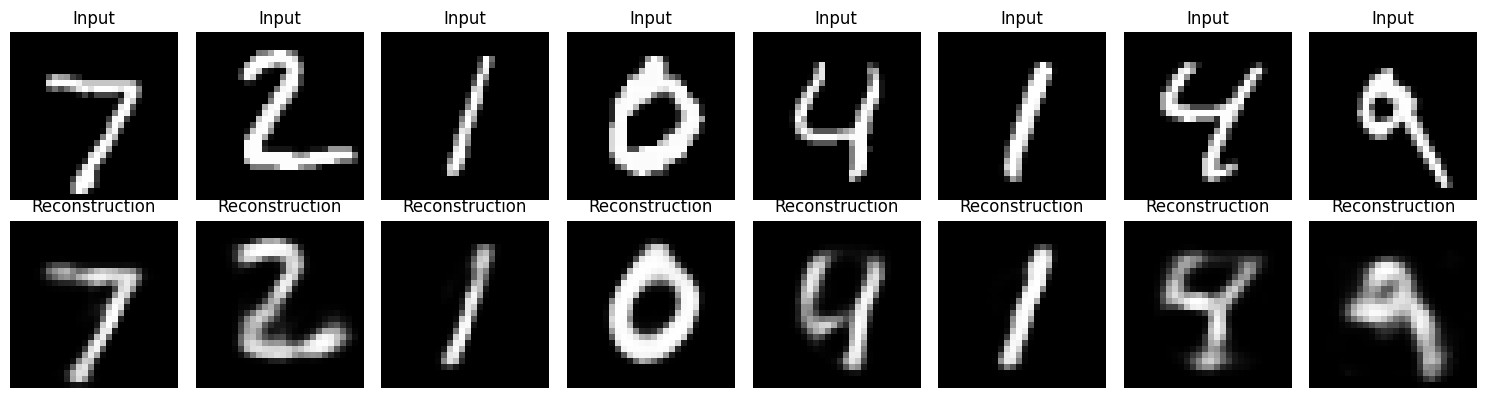

已儲存重建圖檔 reconstruction.png


In [5]:
# 執行主程序
if __name__ == "__main__":
  main()